# Credit Card Fraud Detection

## Required libraries 

In [252]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from adjustText import adjust_text
from geopy.distance import geodesic
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
import pickle
import os
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


# Task 1: Data Understanding, Preparation and Descriptive Analytics

## Introduction

This report presents an exploratory analysis of the dataset provided for the Fraud Detection project. The dataset includes transaction records, customer demographics, merchant details, and city-level information. The primary objective of this analysis is to understand the data structure, identify key patterns, and prepare it for predictive modeling to classify transactions as fraudulent or legitimate.



## 1.1- Data Understanding

Data understanding is a critical step in any fraud detection project, as it involves exploring and analyzing the dataset to gain insights into its structure, content, and relevance for identifying fraudulent activities. This will help to ensure that the data aligns with the objectives of the fraud detection system and lays the foundation for effective model development and analysis. 

This phase will involve merging multiple datasets into a cohesive structure, examining the data to understand its content and quality, and summarizing key attributes to uncover initial patterns and relationships.

### <u>Merge the Datasets</u>

The first step involved merging the datasets to form a unified dataset for analysis. 

I used the function `merge` from pandas library that implements SQL style joining operations.

In this case, `transactions` is our primary dataset, with each row representing a transaction record. I want to ensure that every transaction is retained in the final merged dataset, even if certain demographic, merchant, or city information is missing.

Using `how='left'` for each merge step ensures **all transactions are retained** in the final dataset, even if:

- **Customer data is missing**: Transactions without a matching `cc_num` in `customers` will still appear, with `NaN` for customer details

- **Merchant information is missing**: Transactions lacking a matching `merchant` in `merchants` are included, with `NaN` for merchant fields

- **City data is missing**: If a customer’s `city` has no match in `cities`, the transaction is kept with `NaN` for city details


In [253]:

# Load Datasets
transactions = pd.read_csv('data/transactions.csv')
merchants = pd.read_csv('data/merchants.csv')
customers = pd.read_csv('data/customers.csv')
cities = pd.read_csv('data/cities.csv')

# Merge the .csv files into one
merged_data = pd.merge(transactions, customers, on='cc_num', how='left')
merged_data = pd.merge(merged_data, merchants, on='merchant', how='left')
merged_data = pd.merge(merged_data, cities, on='city', how='left')

# Print merged dataset
print(merged_data.head())

# Save merged dataset into new file
merged_data.to_csv('data/merged_data.csv', index=False)

   index trans_date_trans_time            cc_num device_os     merchant  \
0   5381   2023-01-01 00:39:03  2801374844713453       NaN  Merchant_85   
1   4008   2023-01-01 01:16:08  3460245159749480       NaN  Merchant_23   
2   1221   2023-01-01 01:24:28  7308701990157768     macOS  Merchant_70   
3   9609   2023-01-01 02:06:57  8454886440761098       X11  Merchant_33   
4   5689   2023-01-01 02:10:54  6350332939133843       NaN  Merchant_90   

      amt     trans_num   unix_time  is_fraud  first  ...      job  \
0  252.75  TRANS_662964  1672533543         0   Jane  ...      NaN   
1  340.17  TRANS_134939  1672535768         0  Alice  ...    Nurse   
2   76.38  TRANS_258923  1672536268         0    Bob  ...   Doctor   
3  368.88  TRANS_226814  1672538817         0   Mike  ...  Teacher   
4  323.32  TRANS_668449  1672539054         0   Mike  ...    Nurse   

          dob       category  merch_lat  merch_long merchant_id      lat  \
0  2002-10-12            NaN        NaN   76.433212 

### <u>Data Examination</u> 


After merging, the dataset was examined for its structure and attribute types. Below is a brief description of the key attributes:

| **Attribute**           | **Data Type**       | **Description**                                                                                       |
|--------------------------|---------------------|-------------------------------------------------------------------------------------------------------|
| `index`                 | Categorical  (Nominal)  | Index of the transaction record.                                                                     |
| `trans_date_trans_time` | Categorical (Ordinal)          | Transaction date and time.                                                                           |
| `cc_num`                | Categorical  (Nominal) | Credit card number used for the transaction.                                                         |
| `device_os`             | Categorical (Nominal)       | Operating system of the device used (Windows, macOS, Linux, X11, other).                             |
| `merchant`              | Categorical  (Nominal)       | Name of the merchant involved in the transaction.                                                    |
| `amt`                   | Numerical (Ratio)| Monetary amount of the transaction.                                                                  |
| `trans_num`             | Categorical  (Nominal)       | Unique transaction identifier.                                                                       |
| `unix_time`             | Numerical   (Interval)        | Unix timestamp of the transaction (seconds since January 1, 1970).                                   |
| `is_fraud`              | Categorical (Nominal)  | Indicates if the transaction was fraudulent (1 for fraud, 0 otherwise).                              |
| `category`              | Categorical (Nominal)        | Business category of the merchant (e.g., groceries, travel).                                         |
| `merch_lat`             | Numerical (Ratio)| Latitude of the merchant's location.                                                                 |
| `merch_long`            | Numerical (Ratio)| Longitude of the merchant's location.                                                                |
| `merchant_id`           | Categorical (Nominal)       | Unique identifier for the merchant.                                                                  |
| `first`                 | Categorical (Nominal)        | Customer's first name.                                                                               |
| `last`                  | Categorical (Nominal)       | Customer's last name.                                                                                |
| `gender`                | Categorical (Nominal)        | Customer's gender.                                                                                   |
| `street`                | Categorical (Nominal)        | Customer's street address.                                                                           |
| `city`                  | Categorical (Nominal)       | City where the customer resides.                                                                     |
| `zip`                   | Categorical (Nominal)        | Zip code of the customer's address.                                                                  |
| `job`                   | Categorical  (Nominal)       | Customer's job/profession.                                                                           |
| `dob`                   | Categorical (Ordinal)           | Customer's date of birth.                                                                            |
| `name`                  | Categorical  (Nominal)       | Name of the city.                                                                                    |
| `lat`                   | Numerical (Ratio) | Latitude of the city.                                                                                |
| `long`                  |Numerical (Ratio)| Longitude of the city.                                                                               |
| `city_pop`              | Numerical (Ratio)        | Population of the city.                                                                              |
| `state`                 | Categorical  (Nominal)      | State where the city is located.                                                                     |


### <u>Data Summarization</u>


Data summarization is a foundational step that transforms raw data into actionable insights. It ensures that subsequent processes, like data visualization, feature engineering, and modeling, are based on a well-understood dataset, ultimately leading to better analytical outcomes.

In [254]:

# Load the merged dataset
merged_data = pd.read_csv('data/merged_data.csv')

print("General Information:")
print(merged_data.info())


General Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   index                  30000 non-null  int64  
 1   trans_date_trans_time  29900 non-null  object 
 2   cc_num                 30000 non-null  int64  
 3   device_os              12036 non-null  object 
 4   merchant               30000 non-null  object 
 5   amt                    29900 non-null  float64
 6   trans_num              30000 non-null  object 
 7   unix_time              30000 non-null  int64  
 8   is_fraud               30000 non-null  int64  
 9   first                  29990 non-null  object 
 10  last                   29990 non-null  object 
 11  gender                 29990 non-null  object 
 12  street                 29990 non-null  object 
 13  city                   29990 non-null  object 
 14  zip                    29784 non-

In [255]:
# Select numerical columns excluding irrelevant ones
numerical_columns = merged_data.select_dtypes(include=["number"]).drop(['index', 'cc_num', 'merchant_id','zip','merch_lat','merch_long','lat','long'], axis=1)

# Display summary statistics for numerical columns
print("\nSummary Statistics for Numerical Variables:")
numerical_columns.describe()


Summary Statistics for Numerical Variables:


,amt,unix_time,is_fraud,city_pop
count,29900.000000,3.000000e+04,30000.000000,1.002000e+04
mean,250.063287,1.705650e+09,0.019033,3.704410e+06
std,144.106058,1.530499e+07,0.136644,2.323382e+06
min,1.010000,1.672534e+09,0.000000,1.680992e+06
25%,125.235000,1.696269e+09,0.000000,2.328000e+06
50%,249.625000,1.706376e+09,0.000000,2.716000e+06
75%,375.242500,1.718328e+09,0.000000,3.979576e+06
max,499.970000,1.730124e+09,1.000000,8.419600e+06


In [256]:
# Select categorical columns
categorical_columns = merged_data.select_dtypes(include=["object"])

# Display summary statistics for categorical columns
print("\nSummary Statistics for Categorical Variables:")
categorical_columns.describe()



Summary Statistics for Categorical Variables:


,trans_date_trans_time,device_os,merchant,trans_num,first,last,gender,street,city,job,dob,category,state
count,29900,12036,30000,30000,29990,29990,29990,29990,29990,29784,29990,29401,10020
unique,29868,5,101,29470,108,108,2,102,6,7,1062,5,5
top,2023-10-20 21:24:16,Windows,Merchant_72,TRANS_600014,Jane,Williams,F,Elm St,Test City,Lawyer,1965-10-17,Groceries,CA
freq,2,3049,339,4,1489,1442,15414,1780,19970,6443,237,7193,2181


**Note:**

I removed some atributes from the summary table for numerical variables because these attributes are either irrelevant for descriptive analysis or do not provide meaningful insights in the context of summarization. By excluding these attributes, the summary focuses on numerical variables that have genuine analytical significance.


**Analysis:**

The summary statistics reveal key characteristics of the dataset. Transaction amounts range from small to mid-sized values, with a mean of 250.06, indicating a relatively consistent distribution. Fraudulent transactions are rare, accounting for only 1.9% of the data, highlighting a significant class imbalance that must be addressed during modeling. device_os has a high proportion of missing values, while "Test City" dominates the city field, likely indicating synthetic or placeholder data. The dataset includes a diverse set of merchants and categories, with "Groceries" being the most frequent category. These insights emphasize the need to handle missing values, investigate synthetic data, and carefully address class imbalance to ensure effective analysis and modeling.

#### Correlation Matrix

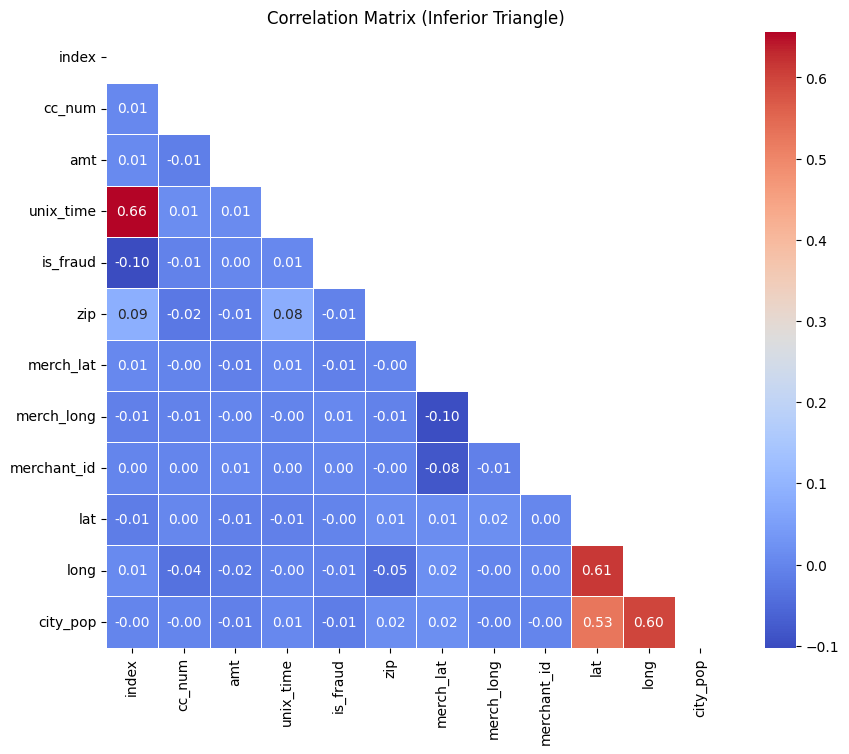

In [257]:
relevant_columns = merged_data.select_dtypes(include=['float64', 'int64']).columns
filtered_data = merged_data[relevant_columns]


correlation_matrix = filtered_data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix (Inferior Triangle)')
plt.show()

Most variables show weak or no significant correlation with each other, indicating that they are largely independent or represent distinct aspects of the data. One notable exception is the strong positive correlation (0.66) between `unix_time` and `index`, which is expected since `index` likely reflects the chronological order of transactions and naturally aligns with the Unix timestamp.

Variables related to city-level information, such as `city_pop`, `lat`, and `long`, exhibit moderate correlations. Specifically, `city_pop` has a positive correlation with both `lat` (0.53) and `long` (0.60), suggesting that high-population cities tend to cluster in specific geographic regions. This geographic relationship may play a role in understanding transaction patterns.

Interestingly, the target variable `is_fraud` does not show any strong correlation with other features. This suggests that fraud detection in this dataset might rely on more complex or non-linear patterns that are not captured by simple correlations. As a result, identifying fraud will likely require advanced feature engineering and sophisticated modeling techniques.

### <u>Data Visualization</u>

Data visualization is an essential step in understanding and presenting data. It simplifies complex information, uncovers hidden patterns, and supports informed decision-making. By using appropriate visualization techniques, analysts can effectively interpret relationships, trends, and anomalies, setting the stage for robust data preparation and modeling.

#### Fraud distribution

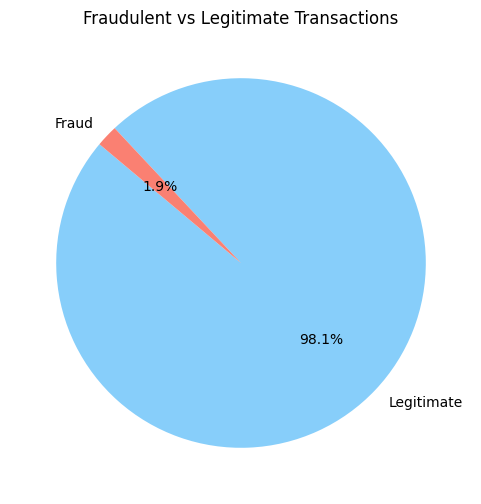

In [258]:
# Pie chart plot
fraud_counts = merged_data['is_fraud'].value_counts(normalize=True)
labels = ['Legitimate', 'Fraud']
plt.figure(figsize=(6, 6))
plt.pie(fraud_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=['lightskyblue', 'salmon'])
plt.title('Fraudulent vs Legitimate Transactions')
plt.show()

**What was done:**

A pie chart was created to visualize the proportion of fraudulent transactions (`is_fraud` = 1) versus legitimate transactions (`is_fraud` = 0). The values were normalized to show the percentage distribution.

**Analysis:**

The chart reveals a significant class imbalance, with fraudulent transactions accounting for only 1.9% of all transactions. This imbalance highlights the importance of addressing this issue during model training, as it may lead to biased predictions favoring the majority class (legitimate transactions). Techniques like oversampling, undersampling, or cost-sensitive modeling will be essential.

#### Distribution of transaction amount

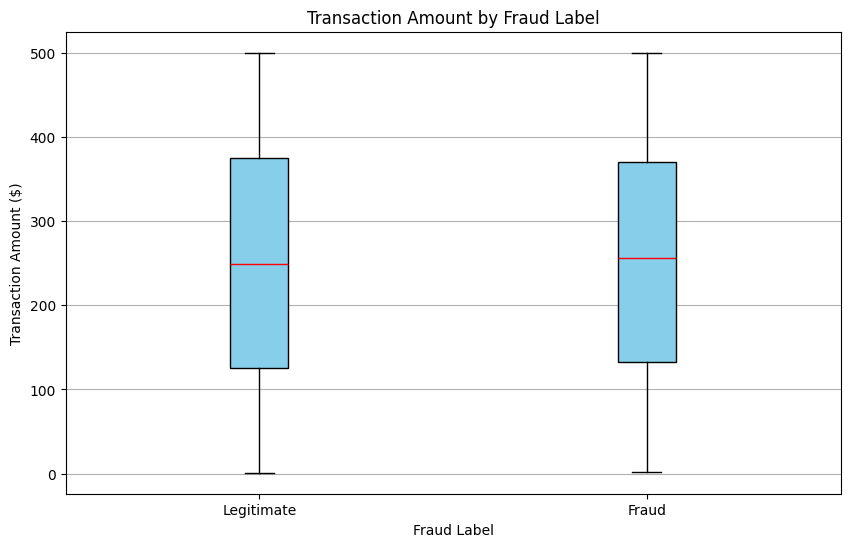

In [259]:

# Filter data for visualization
fraud = merged_data[merged_data['is_fraud'] == 1]['amt']
legit = merged_data[merged_data['is_fraud'] == 0]['amt']

# Limit the range for better visualization
fraud = fraud[fraud <= 500]
legit = legit[legit <= 500]

# Box plot
plt.figure(figsize=(10, 6))
plt.boxplot([legit, fraud], tick_labels=['Legitimate', 'Fraud'], patch_artist=True,
            boxprops=dict(facecolor='skyblue', color='black'),
            medianprops=dict(color='red'))
plt.title('Transaction Amount by Fraud Label')
plt.xlabel('Fraud Label')
plt.ylabel('Transaction Amount ($)')
plt.grid(axis='y')
plt.show()

**What was done:**

A box plot was created to compare the transaction amounts for fraudulent and legitimate transactions. To improve visibility, the range was limited to transactions under $500, because there are no transactions above that value.

**Analysis:**

The box plot shows that fraudulent transactions tend to have higher median amounts compared to legitimate ones. This suggests that fraudsters may target higher-value transactions. However, there is overlap between the distributions, indicating that transaction amount alone may not be a definitive predictor of fraud.

#### Fraud rate by merchant category

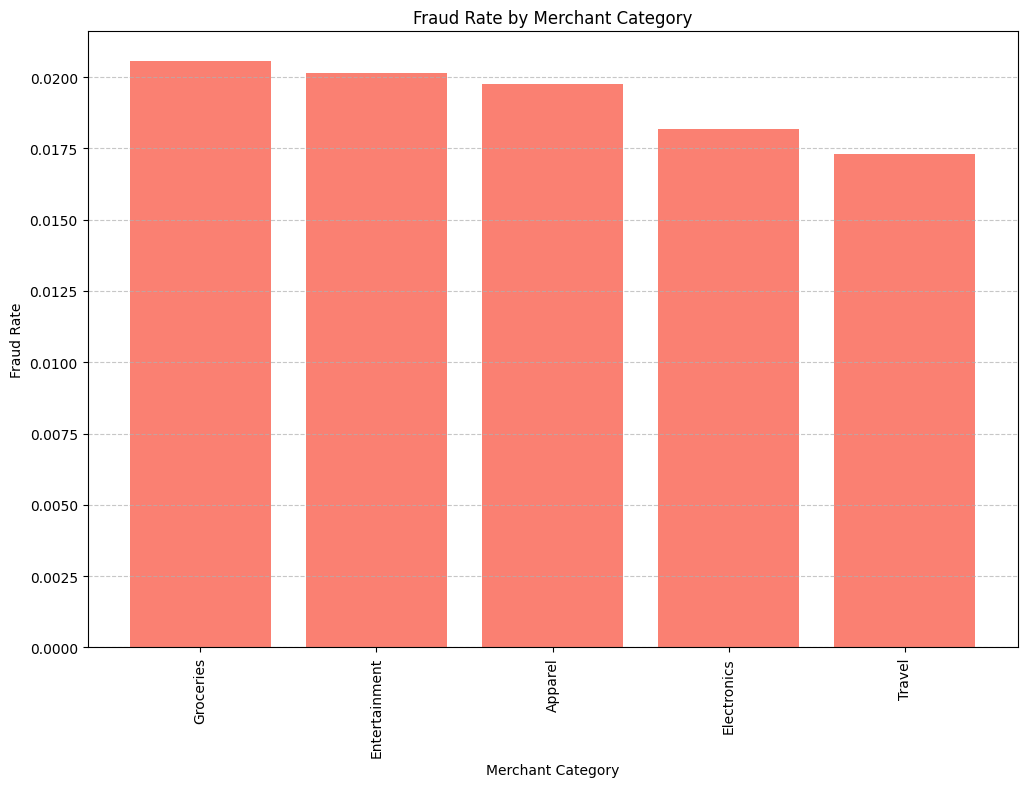

In [260]:

fraud_rate = merged_data.groupby('category')['is_fraud'].mean().sort_values(ascending=False)

# Bar plot
plt.figure(figsize=(12, 8))
plt.bar(fraud_rate.index, fraud_rate.values, color='salmon')
plt.xticks(rotation=90)
plt.title('Fraud Rate by Merchant Category')
plt.xlabel('Merchant Category')
plt.ylabel('Fraud Rate')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**What was done:**

A bar plot was used to display the average fraud rate for each merchant category, calculated by grouping the data by `category` and taking the mean of `is_fraud`.

**Analysis:**

The chart reveals that certain merchant categories, such as "Groceries" and "Entertainment," have slightly higher fraud rates. This insight could be useful for identifying high-risk merchant categories. However, the differences between categories are not dramatic, suggesting that other factors may play a more significant role in fraud.

#### OS Used in Transactions

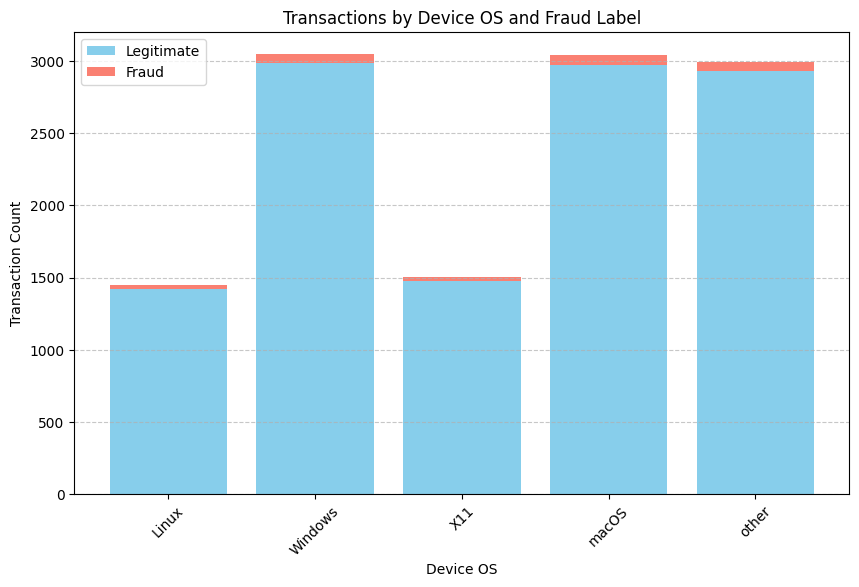

In [261]:
# Count of transactions by device_os and fraud label
device_os_counts = merged_data.groupby(['device_os', 'is_fraud']).size().unstack(fill_value=0)

# Stacked bar plot
device_os = device_os_counts.index
legit_counts = device_os_counts[0]
fraud_counts = device_os_counts[1]

x = range(len(device_os))
plt.figure(figsize=(10, 6))
plt.bar(x, legit_counts, label='Legitimate', color='skyblue')
plt.bar(x, fraud_counts, label='Fraud', bottom=legit_counts, color='salmon')

plt.xticks(x, device_os, rotation=45)
plt.title('Transactions by Device OS and Fraud Label')
plt.xlabel('Device OS')
plt.ylabel('Transaction Count')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**What was done:**

A stacked bar plot was created to compare the number of transactions for each device_os, split by fraud label (is_fraud).

**Analysis:**

The chart shows that Windows and macOS have the highest number of both legitimate and fraudulent transactions, likely reflecting their popularity among users. However, the proportion of fraudulent transactions does not vary significantly across operating systems. This indicates that device OS may not be a strong standalone feature for fraud detection.

#### Fraud Rate by City

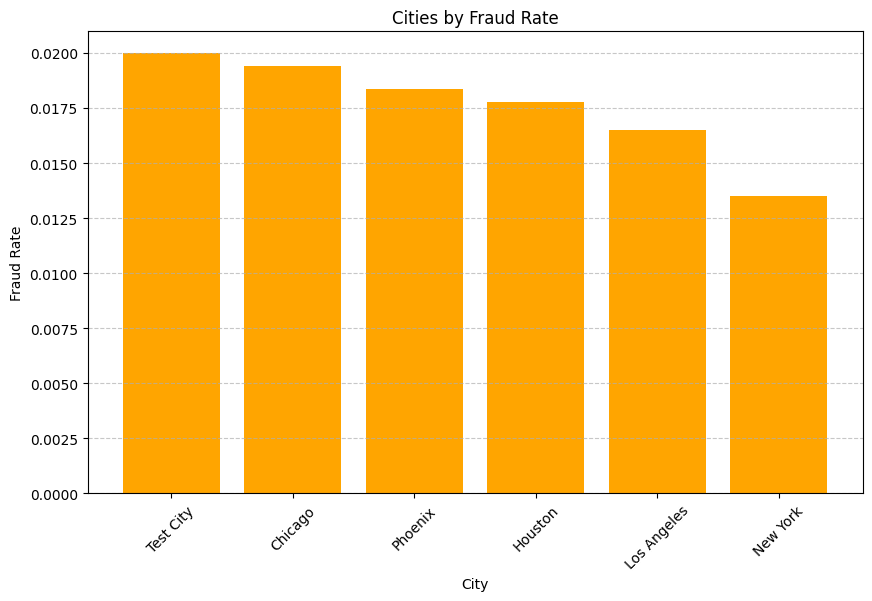

In [262]:
# Calculate fraud rate per city
city_fraud_rate = merged_data.groupby('city')['is_fraud'].mean().sort_values(ascending=False)

# Bar plot for fraud rate by city
plt.figure(figsize=(10, 6))
plt.bar(city_fraud_rate.index, city_fraud_rate.values, color='orange')
plt.title('Cities by Fraud Rate')
plt.xlabel('City')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**What was done:**

A bar plot was created to show the cities with the highest fraud rates. The fraud rate for each city was calculated as the mean of `is_fraud`.

**Analysis:**

The chart indicates that major metropolitan areas such as Chicago, Phoenix and Houston have higher fraud rates. Upon further inspection, the inclusion of "Test City" appears to be a synthetic or placeholder entry in the dataset rather than a real location. This type of entry is likely used for testing purposes or as a default value and does not represent actual transactional data.

Its presence can distort the analysis by introducing artificial patterns or biasing the interpretation of fraud rates. For this reason, "Test City" should be excluded from the analysis to ensure that insights are based solely on genuine and reliable data. Further exploration of the relationship between fraud rates and factors such as city population, transaction volume, or merchant density can help uncover the underlying dynamics contributing to higher fraud rates in specific cities.

#### Fraud Rate by Hour of Day

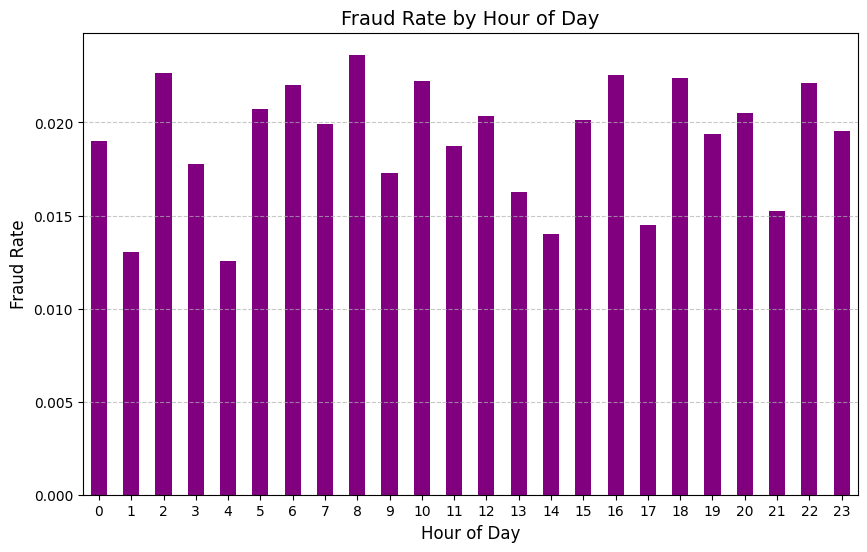

In [263]:
# Convert Unix time to datetime and extract the hour
merged_data['hour'] = pd.to_datetime(merged_data['unix_time'], unit='s').dt.hour

# Group by hour and calculate fraud rate
fraud_rate_by_hour = merged_data.groupby('hour')['is_fraud'].mean()

merged_data.drop('hour', axis=1, inplace=True)

# Bar plot
plt.figure(figsize=(10, 6))
fraud_rate_by_hour.plot(kind='bar', color='purple')
plt.title('Fraud Rate by Hour of Day', fontsize=14)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Fraud Rate', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**What was done:**

This bar plot visualizes the fraud rate across different hours of the day. The hour was extracted from the unix_time column, and the fraud rate (is_fraud) was calculated as the mean of fraud labels for each hour. This provides insight into the temporal patterns of fraudulent activity.

**Analysis:**

While there are peaks and dips, the fraud rate does not vary drastically across hours, suggesting that fraud occurs throughout the day with certain periods being slightly riskier.

#### Geographic Distribution of Fraudulent Transactions and Cities

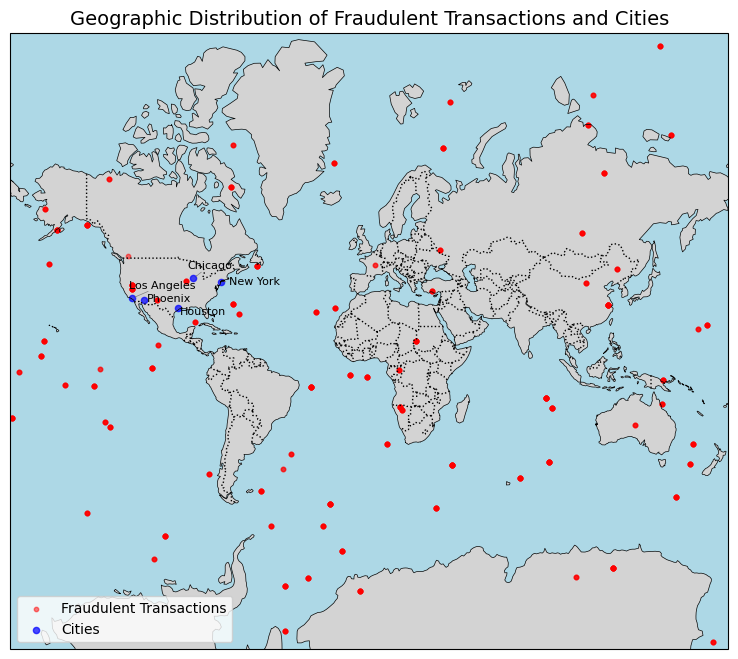

In [264]:
# Filter fraudulent transactions
fraud_data = merged_data[merged_data['is_fraud'] == 1]

# Filter unique cities with valid coordinates
city_data_clean = merged_data[['city', 'lat', 'long']].drop_duplicates().dropna(subset=['lat', 'long'])

# Create a figure and set up a map projection (Mercator)
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.Mercator())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot fraudulent transactions as scatter points
plt.scatter(
    fraud_data['merch_long'], fraud_data['merch_lat'],
    color='red', alpha=0.5, s=10, transform=ccrs.PlateCarree(),
    label='Fraudulent Transactions'
)

# Plot city locations as blue scatter points
plt.scatter(
    city_data_clean['long'], city_data_clean['lat'],
    color='blue', alpha=0.7, s=20, transform=ccrs.PlateCarree(),
    label='Cities'
)

# Add city labels with adjustText
texts = []
for _, row in city_data_clean.iterrows():
    texts.append(plt.text(
        row['long'], row['lat'], row['city'],
        fontsize=8, transform=ccrs.PlateCarree(), color='black'
    ))
# Adjust text to avoid overlaps
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='gray', lw=0.5))

# Add title and legend
plt.title('Geographic Distribution of Fraudulent Transactions and Cities', fontsize=14)
plt.legend(loc='lower left', fontsize=10)

# Set extent (map boundaries) based on the data
plt.gca().set_extent([
    min(city_data_clean['long'].min(), fraud_data['merch_long'].min()) - 1,
    max(city_data_clean['long'].max(), fraud_data['merch_long'].max()) + 1,
    min(city_data_clean['lat'].min(), fraud_data['merch_lat'].min()) - 1,
    max(city_data_clean['lat'].max(), fraud_data['merch_lat'].max()) + 1
], crs=ccrs.PlateCarree())

# Show the plot
plt.show()


**What was done:**

The map shows the geographic distribution of fraudulent transactions (red points) overlaid with city locations (blue points). To improve readability, city labels were dynamically adjusted using the adjustText library to avoid overlapping, with arrows indicating their original positions.

**Analysis:**

While some fraudulent transactions are near major urban centers like New York, Chicago, and Los Angeles, many points appear as outliers, such as those in the ocean or sparsely populated regions. This suggests that the geographic coordinates may lack strong correlation with city locations, likely due to errors or placeholders in the dataset. However, there are clusters of fraudulent transactions near certain cities that could warrant further analysis to identify potential patterns or high-risk areas.

#### Fraud Rate by Customer Age Group

/tmp/ipykernel_11363/2815110579.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate_by_age = merged_data.groupby('age_group')['is_fraud'].mean()


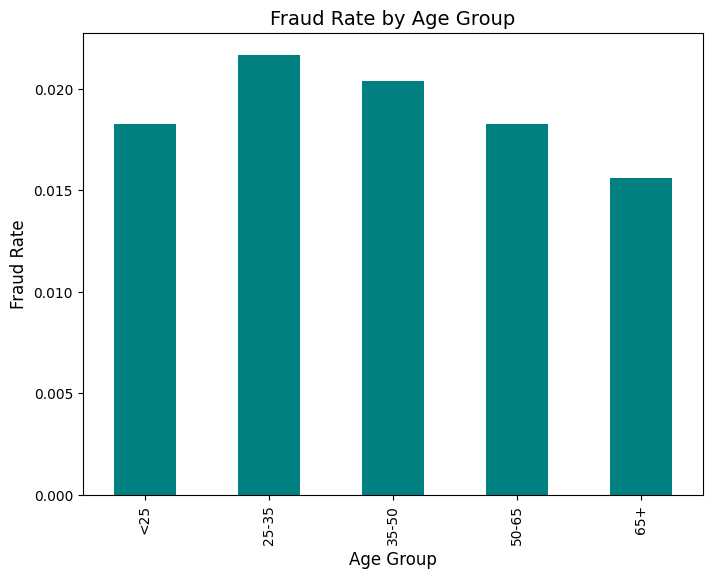

In [265]:
# Calculate age
merged_data['age'] = pd.to_datetime('2023-01-01') - pd.to_datetime(merged_data['dob'])
merged_data['age'] = merged_data['age'].dt.days // 365

# Bin age into groups
bins = [0, 25, 35, 50, 65, 100]
labels = ['<25', '25-35', '35-50', '50-65', '65+']
merged_data['age_group'] = pd.cut(merged_data['age'], bins=bins, labels=labels, right=False)

# Calculate fraud rate by age group
fraud_rate_by_age = merged_data.groupby('age_group')['is_fraud'].mean()

merged_data.drop('age_group', axis=1, inplace=True)

# Bar plot
plt.figure(figsize=(8, 6))
fraud_rate_by_age.plot(kind='bar', color='teal')
plt.title('Fraud Rate by Age Group', fontsize=14)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Fraud Rate', fontsize=12)
plt.show()

**What was done:**

The bar chart displays the fraud rate across different age groups.

**Analysis**:

Fraud rates are higher among individuals aged 25-35 and 35-50, suggesting that these groups may be more frequently targeted by fraudsters or engage more in high-risk transaction behaviors. Conversely, the fraud rate is lower for individuals aged 65+, which could be due to lower transaction volumes or more cautious spending habits in this demographic. While the differences between age groups are not drastic, these insights could inform targeted fraud prevention strategies for higher-risk groups.

#### Fraud Rate by Merchant Category and Age Group

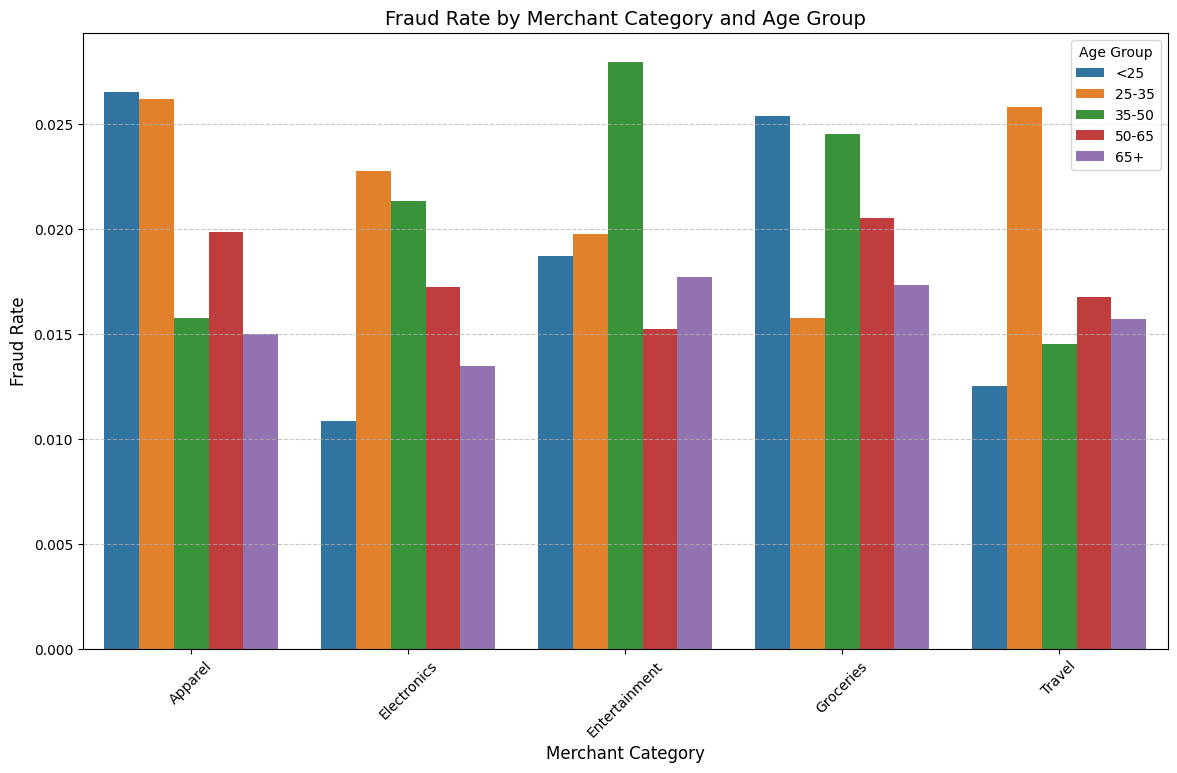

In [266]:
# Calculate age
merged_data['age'] = pd.to_datetime('2023-01-01') - pd.to_datetime(merged_data['dob'])
merged_data['age'] = merged_data['age'].dt.days // 365

# Bin age into groups
bins = [0, 25, 35, 50, 65, 100]
labels = ['<25', '25-35', '35-50', '50-65', '65+']
merged_data['age_group'] = pd.cut(merged_data['age'], bins=bins, labels=labels, right=False)

# Group data by age group and merchant category, then calculate fraud rate
fraud_rate_by_category_age = merged_data.groupby(['age_group', 'category'], observed=True)['is_fraud'].mean().reset_index()

merged_data.drop('age_group', axis=1, inplace=True)

# Plot a grouped bar plot
plt.figure(figsize=(14, 8))
sns.barplot(data=fraud_rate_by_category_age, x='category', y='is_fraud', hue='age_group', errorbar=None)
plt.title('Fraud Rate by Merchant Category and Age Group', fontsize=14)
plt.xlabel('Merchant Category', fontsize=12)
plt.ylabel('Fraud Rate', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Age Group')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**What was done:**

The bar chart shows the fraud rate across merchant categories for different age groups. 

**Analysis:**

Younger groups (<25 and 25-35) have higher fraud rates in categories like Apparel and Travel, while middle-aged groups (35-50) show peaks in Entertainment. Older groups (65+) generally experience lower fraud rates across categories. These patterns suggest that fraudsters may target specific demographics based on category-related behaviors, such as younger individuals in Apparel and Travel or middle-aged individuals in Entertainment. 

### Fraud Rate by Job

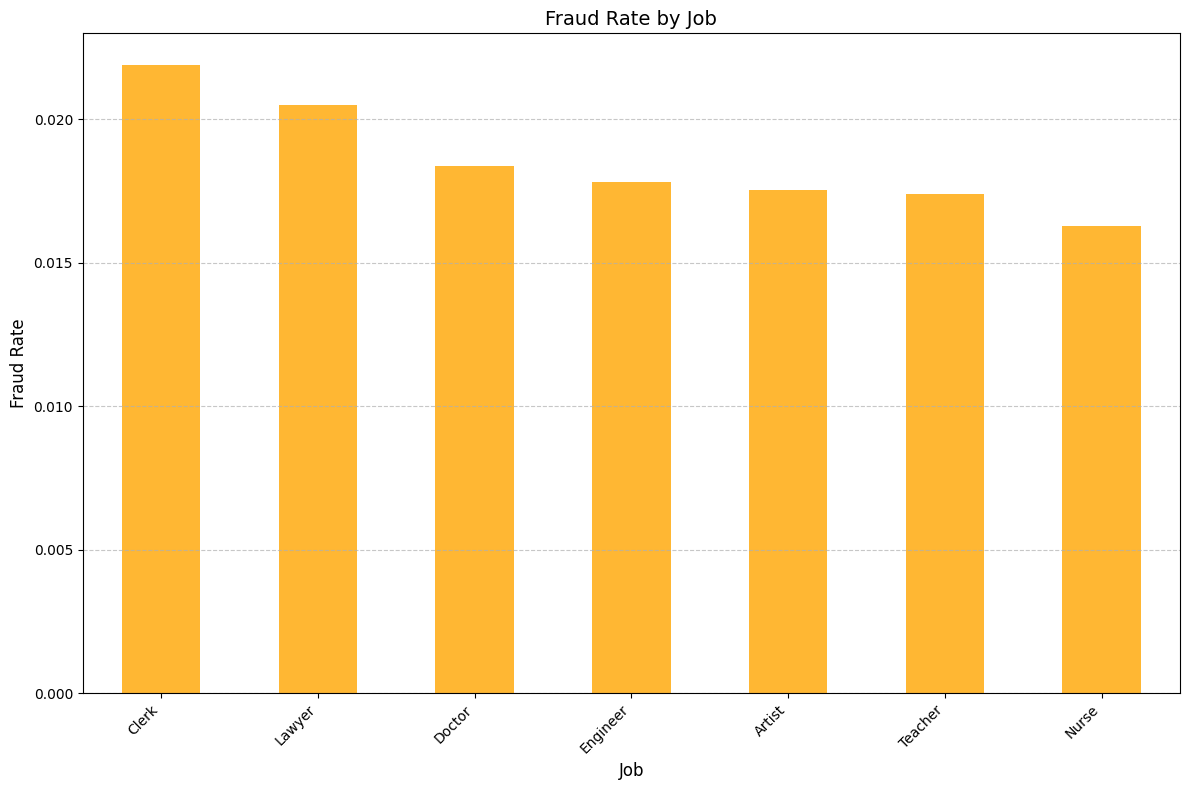

In [267]:
# Calculate fraud rate for each job
fraud_rate_by_job = merged_data.groupby('job')['is_fraud'].mean().sort_values(ascending=False)

# Plot the fraud rate by job
plt.figure(figsize=(12, 8))
fraud_rate_by_job.plot(kind='bar', color='orange', alpha=0.8)
plt.title('Fraud Rate by Job', fontsize=14)
plt.xlabel('Job', fontsize=12)
plt.ylabel('Fraud Rate', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**What was done:**

A bar chart was created to analyze the relationship between customers' jobs and the fraud rate.

**Analysis:**

The chart shows that certain professions, such as Clerks and Lawyers, have slightly higher fraud rates compared to other professions like Teachers and Nurses. These differences might reflect behavioral patterns, spending habits, or exposure to fraud based on the nature of the profession. The fraud rates across jobs are relatively close, indicating that job type alone may not be a strong predictor of fraud but could be considered alongside other features

#### Conclusion on Data Visualization

The analysis revealed several key insights about fraudulent transactions. Fraud is relatively rare in the dataset, accounting for only 1.9% of all transactions, highlighting the challenge of identifying such rare events. Geographic patterns showed clusters of fraudulent transactions near major urban centers, though significant outliers and inconsistent coordinates suggest that location data may not be highly reliable. Fraud rates varied by age group, with younger and middle-aged individuals (25-35 and 35-50) being more frequently targeted, particularly in categories like Apparel, Travel, and Entertainment. Older age groups (65+) generally experienced lower fraud rates. Certain categories, such as Travel and Entertainment, showed higher fraud activity, suggesting specific areas where fraudsters exploit vulnerabilities.

## 1.2- Data Preparation

Data preparation is a critical step in the machine learning pipeline, ensuring that the dataset is clean, consistent, and structured for effective modeling. This process involves handling missing values, encoding categorical variables, creating meaningful features, and addressing potential issues like class imbalance. Proper data preparation enhances the quality of the input data, reduces noise, and helps models better capture underlying patterns. In this project, the data preparation phase focuses on transforming the provided transaction data into a format suitable for building a predictive model to detect fraudulent transactions. This includes cleaning the dataset, engineering new features, scaling numerical variables, and addressing the imbalanced nature of the target variable. These steps aim to improve the accuracy and reliability of the predictive models in identifying fraud.

### <u>Split Data into Train and Test Sets</u>

In [268]:
X = merged_data.drop('is_fraud', axis=1)
y = merged_data['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### <u>Handle Duplicate Values</u>

In [269]:
# Check for duplicate transactions
print("\nDuplicate Transactions:")
print(X_train.duplicated(subset='trans_num').sum())


Duplicate Transactions:
337


In [270]:
# Delete duplicate transactions 
def remove_duplicates(dataframe,dataframe2):
  
    duplicated = dataframe[dataframe.duplicated(subset='trans_num', keep=False)]

    indices_to_keep = (
        duplicated
        .groupby('trans_num')
        .apply(lambda group: group.isnull().sum(axis=1).idxmin())  # Rows with more NaNs
    )

    indices_to_remove = set(duplicated.index) - set(indices_to_keep)

    dataframe_cleaned = dataframe.drop(index=indices_to_remove)
    dataframe2_cleaned = dataframe2.drop(index=indices_to_remove)
    
    return dataframe_cleaned.reset_index(drop=True), dataframe2_cleaned.reset_index(drop=True)

X_train, y_train = remove_duplicates(X_train,y_train)


# Check for duplicate transactions
print("\nDuplicate Transactions:")
print(X_train.duplicated(subset='trans_num').sum())



Duplicate Transactions:
0


/tmp/ipykernel_11363/3258083248.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.isnull().sum(axis=1).idxmin())  # Rows with more NaNs


### <u>Handle Missing Values</u>

In [271]:
# Check for missing values
print("\nMissing Values Train:")
print(X_train.isnull().sum())

X_train.to_csv('X_train_with_missing_values.csv', index=False)



Missing Values Train:
index                        0
trans_date_trans_time       78
cc_num                       0
device_os                14107
merchant                     0
amt                         78
trans_num                    0
unix_time                    0
first                        1
last                         1
gender                       1
street                       1
city                         1
zip                        162
job                        162
dob                          1
category                   447
merch_lat                  447
merch_long                   1
merchant_id                  1
lat                      15636
long                     15636
city_pop                 15636
state                    15636
age                          1
dtype: int64


In [272]:
X_train = pd.read_csv('X_train_without_missing_values.csv')


# Check for missing values
print("\nMissing Values Train:")
print(X_train.isnull().sum())



Missing Values Train:
index                    0
trans_date_trans_time    0
cc_num                   0
device_os                0
merchant                 0
amt                      0
trans_num                0
unix_time                0
first                    0
last                     0
gender                   0
street                   0
city                     0
zip                      0
job                      0
dob                      0
category                 0
merch_lat                0
merch_long               0
merchant_id              0
lat                      0
long                     0
city_pop                 0
state                    0
age                      0
dtype: int64


In [273]:
print("\nMissing Values Test:")
print(X_test.isnull().sum())


Missing Values Test:
index                       0
trans_date_trans_time      21
cc_num                      0
device_os                3615
merchant                    0
amt                        21
trans_num                   0
unix_time                   0
first                       1
last                        1
gender                      1
street                      1
city                        1
zip                        45
job                        45
dob                         1
category                  135
merch_lat                 135
merch_long                  1
merchant_id                 1
lat                      4060
long                     4060
city_pop                 4060
state                    4060
age                         1
dtype: int64


In [274]:
numeric_cols = X_train.select_dtypes(include=["float64", "int64"]).columns
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns

train_means = X_train[numeric_cols].mean()

# Calcular a moda para as colunas categóricas
train_modes = X_train[categorical_cols].mode().iloc[0]

for col in numeric_cols:
    if col in X_test.columns:  # Garantir que a coluna exista no teste
        X_test[col] = X_test[col].fillna(train_means[col])

for col in categorical_cols:
    if col in X_test.columns:  # Garantir que a coluna exista no teste
        X_test[col] = X_test[col].fillna(train_modes[col])


print("\nMissing Values Test:")
print(X_test.isnull().sum())


Missing Values Test:
index                    0
trans_date_trans_time    0
cc_num                   0
device_os                0
merchant                 0
amt                      0
trans_num                0
unix_time                0
first                    0
last                     0
gender                   0
street                   0
city                     0
zip                      0
job                      0
dob                      0
category                 0
merch_lat                0
merch_long               0
merchant_id              0
lat                      0
long                     0
city_pop                 0
state                    0
age                      0
dtype: int64


### <u>Feature Engineering</u>

In [275]:
'''
# Convert unix_time to datetime
X_train['datetime'] = pd.to_datetime(X_train['unix_time'], unit='s')

# Extract hour, day of the week, and month
X_train['hour'] = X_train['datetime'].dt.hour
X_train['day_of_week'] = X_train['datetime'].dt.dayofweek  # 0=Monday, 6=Sunday
X_train['month'] = X_train['datetime'].dt.month

# Drop the intermediate 'datetime' column if not needed
X_train.drop('datetime', axis=1, inplace=True)


# Convert unix_time to datetime
X_test['datetime'] = pd.to_datetime(X_test['unix_time'], unit='s')

# Extract hour, day of the week, and month
X_test['hour'] = X_test['datetime'].dt.hour
X_test['day_of_week'] = X_test['datetime'].dt.dayofweek  # 0=Monday, 6=Sunday
X_test['month'] = X_test['datetime'].dt.month

# Drop the intermediate 'datetime' column if not needed
X_test.drop('datetime', axis=1, inplace=True)
'''

"\n# Convert unix_time to datetime\nX_train['datetime'] = pd.to_datetime(X_train['unix_time'], unit='s')\n\n# Extract hour, day of the week, and month\nX_train['hour'] = X_train['datetime'].dt.hour\nX_train['day_of_week'] = X_train['datetime'].dt.dayofweek  # 0=Monday, 6=Sunday\nX_train['month'] = X_train['datetime'].dt.month\n\n# Drop the intermediate 'datetime' column if not needed\nX_train.drop('datetime', axis=1, inplace=True)\n\n\n# Convert unix_time to datetime\nX_test['datetime'] = pd.to_datetime(X_test['unix_time'], unit='s')\n\n# Extract hour, day of the week, and month\nX_test['hour'] = X_test['datetime'].dt.hour\nX_test['day_of_week'] = X_test['datetime'].dt.dayofweek  # 0=Monday, 6=Sunday\nX_test['month'] = X_test['datetime'].dt.month\n\n# Drop the intermediate 'datetime' column if not needed\nX_test.drop('datetime', axis=1, inplace=True)\n"

In [276]:
#merged_data['distance'] = merged_data.apply(lambda row: geodesic((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])).km, axis=1)

In [277]:
def calculate_age_and_group(data):
    # Calcular a idade
    data['age'] = pd.to_datetime('2023-01-01') - pd.to_datetime(data['dob'])
    data['age'] = data['age'].dt.days // 365

    # Binarizar a idade em grupos
    bins = [0, 25, 35, 50, 65, 100]
    labels = ['<25', '25-35', '35-50', '50-65', '65+']
    data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=False)
    return data

X_train = calculate_age_and_group(X_train)
X_test = calculate_age_and_group(X_test)

In [278]:
X_train['merchant_category_age_group'] = (
    X_train['category'] + '_' + X_train['age_group'].astype(str)
)

X_test['merchant_category_age_group'] = (
    X_test['category'] + '_' + X_test['age_group'].astype(str)
)

In [279]:
high_risk_age_groups = ['25-35']
X_train['is_high_risk_age_group'] = X_train['age_group'].apply(lambda x: 1 if x in high_risk_age_groups else 0)
X_test['is_high_risk_age_group'] = X_test['age_group'].apply(lambda x: 1 if x in high_risk_age_groups else 0)


In [280]:
high_risk_jobs = ['Clerk', 'Lawyer']
X_train['job_risk_level'] = X_train['job'].apply(lambda x: 'high' if x in high_risk_jobs else 'low')
X_test['job_risk_level'] = X_test['job'].apply(lambda x: 'high' if x in high_risk_jobs else 'low')


### <u>Encode Categorical Variables</u>

In [281]:
# One-hot encoding example
X_train = pd.get_dummies(X_train, columns=['category', 'age_group', 'job_risk_level','is_high_risk_age_group','merchant_category_age_group'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['category', 'age_group', 'job_risk_level','is_high_risk_age_group','merchant_category_age_group'], drop_first=True)

X_train = X_train.rename(columns={
    'is_high_risk_age_group_0.0': 'is_high_risk_age_group_0',
    'is_high_risk_age_group_1.0': 'is_high_risk_age_group_1'
})

X_test = X_test.rename(columns={
    'is_high_risk_age_group_0.0': 'is_high_risk_age_group_0',
    'is_high_risk_age_group_1.0': 'is_high_risk_age_group_1'
})

### <u>Drop Redundant or Unnecessary Columns</u>

In [282]:
X_train.drop(['index','cc_num','trans_num', 'unix_time', 'trans_date_trans_time','zip','first','last','gender','street','dob','state'
                  ,'lat','long','merch_lat','merch_long','job','city','age','merchant_id'
                  ,'city_pop','merchant','device_os'], axis=1, inplace=True)

X_test.drop(['index','cc_num','trans_num', 'unix_time', 'trans_date_trans_time','zip','first','last','gender','street','dob','state'
                  ,'lat','long','merch_lat','merch_long','job','city','age','merchant_id'
                  ,'city_pop','merchant','device_os'], axis=1, inplace=True)

X_train.columns = X_train.columns.str.replace('[\[\]<>,]', '', regex=True)
X_test.columns = X_test.columns.str.replace('[\[\]<>,]', '', regex=True)

<>:9: SyntaxWarning: invalid escape sequence '\['
<>:10: SyntaxWarning: invalid escape sequence '\['
<>:9: SyntaxWarning: invalid escape sequence '\['
<>:10: SyntaxWarning: invalid escape sequence '\['
/tmp/ipykernel_11363/217881351.py:9: SyntaxWarning: invalid escape sequence '\['
  X_train.columns = X_train.columns.str.replace('[\[\]<>,]', '', regex=True)
/tmp/ipykernel_11363/217881351.py:10: SyntaxWarning: invalid escape sequence '\['
  X_test.columns = X_test.columns.str.replace('[\[\]<>,]', '', regex=True)


In [283]:
X_train.head()

,amt,category_Electronics,category_Entertainment,category_Groceries,category_Travel,age_group_25-35,age_group_35-50,age_group_50-65,age_group_65+,job_risk_level_low,...,merchant_category_age_group_Groceries_25-35,merchant_category_age_group_Groceries_35-50,merchant_category_age_group_Groceries_50-65,merchant_category_age_group_Groceries_65+,merchant_category_age_group_Groceries_25,merchant_category_age_group_Travel_25-35,merchant_category_age_group_Travel_35-50,merchant_category_age_group_Travel_50-65,merchant_category_age_group_Travel_65+,merchant_category_age_group_Travel_25
0,328.06,False,False,False,False,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,313.53,True,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,255.81,True,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
3,222.52,False,False,True,False,False,False,True,False,True,...,False,False,True,False,False,False,False,False,False,False
4,117.32,True,False,False,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False


In [284]:
X_test.head()

,amt,category_Electronics,category_Entertainment,category_Groceries,category_Travel,age_group_25-35,age_group_35-50,age_group_50-65,age_group_65+,job_risk_level_low,...,merchant_category_age_group_Groceries_25-35,merchant_category_age_group_Groceries_35-50,merchant_category_age_group_Groceries_50-65,merchant_category_age_group_Groceries_65+,merchant_category_age_group_Groceries_25,merchant_category_age_group_Travel_25-35,merchant_category_age_group_Travel_35-50,merchant_category_age_group_Travel_50-65,merchant_category_age_group_Travel_65+,merchant_category_age_group_Travel_25
24161,31.20,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2107,139.18,False,False,True,False,False,False,True,False,True,...,False,False,True,False,False,False,False,False,False,False
27695,297.05,False,False,False,True,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
11110,122.39,False,False,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
28450,413.40,False,True,False,False,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


### <u>Normalize/Scale Numerical Features</u>

In [285]:
numerical_columns = ['amt'] # Maybe add more numeric collums
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])

### <u>Class Imbalance</u>

In [286]:
#X = merged_data.drop('is_fraud', axis=1)
#y = merged_data['is_fraud']


smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

## 1.3- Clustering

### DBSCAN

In [287]:
"""
# Select numerical features for clustering
features = ['amt', 'hour']  # Replace with features relevant to your data
data_subset = merged_data[features].dropna()

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_subset)

# Apply DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=10)  # Adjust `eps` and `min_samples` as needed
clusters = dbscan.fit_predict(scaled_features)

# Add cluster labels to the dataset
merged_data['cluster'] = clusters

# Visualize the clusters 
sns.scatterplot(data=merged_data, x='amt', y='hour', hue='cluster', palette='tab10')
plt.title('DBSCAN Clustering of Transactions')
plt.show()
"""


"\n# Select numerical features for clustering\nfeatures = ['amt', 'hour']  # Replace with features relevant to your data\ndata_subset = merged_data[features].dropna()\n\n# Standardize the features\nscaler = StandardScaler()\nscaled_features = scaler.fit_transform(data_subset)\n\n# Apply DBSCAN\ndbscan = DBSCAN(eps=1.5, min_samples=10)  # Adjust `eps` and `min_samples` as needed\nclusters = dbscan.fit_predict(scaled_features)\n\n# Add cluster labels to the dataset\nmerged_data['cluster'] = clusters\n\n# Visualize the clusters \nsns.scatterplot(data=merged_data, x='amt', y='hour', hue='cluster', palette='tab10')\nplt.title('DBSCAN Clustering of Transactions')\nplt.show()\n"

### K-Means

In [ ]:
"""
# Aggregate data by customer
customer_data = merged_data.groupby('cc_num').agg({
    'amt': 'mean',  # Average transaction amount
    'distance': 'mean',  # Average distance
    'is_fraud': 'mean',  # Fraud rate per customer
    'trans_num': 'count'  # Number of transactions
}).reset_index()

# Select features for clustering
features = ['amt', 'distance', 'is_fraud', 'trans_num']
customer_features = customer_data[features]

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features)

# Apply K-Means
kmeans = KMeans(n_clusters=4, random_state=42)  # Adjust `n_clusters` as needed
customer_data['cluster'] = kmeans.fit_predict(scaled_features)

# Visualize clusters (e.g., fraud rate vs transaction amount)
sns.scatterplot(data=customer_data, x='amt', y='is_fraud', hue='cluster', palette='tab10')
plt.title('Customer Clustering Based on Behavior')
plt.show()

"""

"\n\n# Aggregate data by customer\ncustomer_data = merged_data.groupby('cc_num').agg({\n    'amt': 'mean',  # Average transaction amount\n    'distance': 'mean',  # Average distance\n    'is_fraud': 'mean',  # Fraud rate per customer\n    'trans_num': 'count'  # Number of transactions\n}).reset_index()\n\n# Select features for clustering\nfeatures = ['amt', 'distance', 'is_fraud', 'trans_num']\ncustomer_features = customer_data[features]\n\n# Standardize the data\nscaler = StandardScaler()\nscaled_features = scaler.fit_transform(customer_features)\n\n# Apply K-Means\nkmeans = KMeans(n_clusters=4, random_state=42)  # Adjust `n_clusters` as needed\ncustomer_data['cluster'] = kmeans.fit_predict(scaled_features)\n\n# Visualize clusters (e.g., fraud rate vs transaction amount)\nsns.scatterplot(data=customer_data, x='amt', y='is_fraud', hue='cluster', palette='tab10')\nplt.title('Customer Clustering Based on Behavior')\nplt.show()\n\n"

# Task 2: Predictive Modelling

In [289]:
transactions = pd.read_csv('kaggle-data/test_transactions.csv')
merchants = pd.read_csv('kaggle-data/CreditCardTransactions/CreditCardTransactions/merchants.csv')
customers = pd.read_csv('kaggle-data/CreditCardTransactions/CreditCardTransactions/customers.csv')
cities = pd.read_csv('kaggle-data/CreditCardTransactions/CreditCardTransactions/cities.csv')

# Merge the .csv files into one
kaggle_data = pd.merge(transactions, customers, on='cc_num', how='left')
kaggle_data = pd.merge(kaggle_data, merchants, on='merchant', how='left')
kaggle_data = pd.merge(kaggle_data, cities, on='city', how='left')


#kaggle_data = pd.read_csv('kaggle-data/test_transactions.csv')

#kaggle_data['amt'] = kaggle_data['amt'].fillna(kaggle_data['amt'].mean())


In [290]:
for col in numeric_cols:
    if col in kaggle_data.columns:  # Garantir que a coluna exista no teste
        kaggle_data[col] = kaggle_data[col].fillna(train_means[col])

for col in categorical_cols:
    if col in kaggle_data.columns:  # Garantir que a coluna exista no teste
        kaggle_data[col] = kaggle_data[col].fillna(train_modes[col])


In [291]:
'''
# Assuming `filtered_data` is your DataFrame with missing values
data = kaggle_data.copy()

# Convert categorical variables to numerical while preserving NaN
categorical_cols = data.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    # Temporarily replace NaN with a placeholder (-1)
    data[col] = data[col].fillna('Missing')
    # Encode the categorical values
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le
    # Restore NaN in the data where 'Missing' was encoded
    if col == 'device_os':
        data[col] = data[col].replace(le.transform(['Missing'])[0], np.nan)

# Print the dataset before imputation
print("Data Before Imputation:\n", data)

# Create an object for KNNImputer and apply it to the data
imputer = KNNImputer(n_neighbors=2)
imputed_data = imputer.fit_transform(data)

# Convert the imputed data back to a DataFrame
imputed_data = pd.DataFrame(imputed_data, columns=data.columns)

# Convert the numerical columns for categorical variables back to original labels
for col in categorical_cols:
    le = label_encoders[col]
    imputed_data[col] = imputed_data[col].round().astype(int)  # Ensure integers before decoding
    imputed_data[col] = le.inverse_transform(imputed_data[col])

# Print the dataset after imputation
print("\n\nData After Imputation:\n", imputed_data)

# Check for remaining missing values
print("\nRemaining Missing Values:\n", imputed_data.isna().sum())
'''

'\n# Assuming `filtered_data` is your DataFrame with missing values\ndata = kaggle_data.copy()\n\n# Convert categorical variables to numerical while preserving NaN\ncategorical_cols = data.select_dtypes(include=[\'object\']).columns\nlabel_encoders = {}\n\nfor col in categorical_cols:\n    le = LabelEncoder()\n    # Temporarily replace NaN with a placeholder (-1)\n    data[col] = data[col].fillna(\'Missing\')\n    # Encode the categorical values\n    data[col] = le.fit_transform(data[col])\n    label_encoders[col] = le\n    # Restore NaN in the data where \'Missing\' was encoded\n    if col == \'device_os\':\n        data[col] = data[col].replace(le.transform([\'Missing\'])[0], np.nan)\n\n# Print the dataset before imputation\nprint("Data Before Imputation:\n", data)\n\n# Create an object for KNNImputer and apply it to the data\nimputer = KNNImputer(n_neighbors=2)\nimputed_data = imputer.fit_transform(data)\n\n# Convert the imputed data back to a DataFrame\nimputed_data = pd.DataFrame(

In [292]:
def calculate_age_and_group(data):
    # Calcular a idade
    data['age'] = pd.to_datetime('2023-01-01') - pd.to_datetime(data['dob'])
    data['age'] = data['age'].dt.days // 365

    # Binarizar a idade em grupos
    bins = [0, 25, 35, 50, 65, 100]
    labels = ['<25', '25-35', '35-50', '50-65', '65+']
    data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=False)
    return data

kaggle_data = calculate_age_and_group(kaggle_data)


In [293]:
kaggle_data['merchant_category_age_group'] = (
    kaggle_data['category'] + '_' + kaggle_data['age_group'].astype(str)
)


In [294]:
high_risk_age_groups = ['25-35']
kaggle_data['is_high_risk_age_group'] = kaggle_data['age_group'].apply(lambda x: 1 if x in high_risk_age_groups else 0)


In [295]:
high_risk_jobs = ['Clerk', 'Lawyer']
kaggle_data['job_risk_level'] = kaggle_data['job'].apply(lambda x: 'high' if x in high_risk_jobs else 'low')


In [296]:
# One-hot encoding example
kaggle_data = pd.get_dummies(kaggle_data, columns=['category', 'age_group', 'job_risk_level','is_high_risk_age_group','merchant_category_age_group'], drop_first=True)

kaggle_data = kaggle_data.rename(columns={
    'is_high_risk_age_group_0.0': 'is_high_risk_age_group_0',
    'is_high_risk_age_group_1.0': 'is_high_risk_age_group_1'
})


#numerical_columns = ['amt'] # Maybe add more numeric collums  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! PERGUNTAR se faz sentido Normalization only on train data
#scaler = StandardScaler()
#kaggle_data[numerical_columns] = scaler.fit_transform(kaggle_data[numerical_columns])

index_mapping = kaggle_data['index'].values

kaggle_data.drop(['index','cc_num','trans_num', 'unix_time', 'trans_date_trans_time','zip','first','last','gender','street','dob','state'
                  ,'lat','long','merch_lat','merch_long','job','city','age','merchant_id'
                  ,'city_pop','merchant','device_os'], axis=1, inplace=True)

# NOTE: I had to rename the macOs device from the "test_transactions" to macOS to be the same as the trained model

#kaggle_data.insert(loc=35, column='device_os_Windows', value=0)


kaggle_data.columns = kaggle_data.columns.str.replace('[\[\]<>,]', '', regex=True)

<>:25: SyntaxWarning: invalid escape sequence '\['
<>:25: SyntaxWarning: invalid escape sequence '\['
/tmp/ipykernel_11363/3291220361.py:25: SyntaxWarning: invalid escape sequence '\['
  kaggle_data.columns = kaggle_data.columns.str.replace('[\[\]<>,]', '', regex=True)


In [297]:
kaggle_data.head()


,amt,category_Electronics,category_Entertainment,category_Groceries,category_Travel,age_group_25-35,age_group_35-50,age_group_50-65,age_group_65+,job_risk_level_low,...,merchant_category_age_group_Groceries_25-35,merchant_category_age_group_Groceries_35-50,merchant_category_age_group_Groceries_50-65,merchant_category_age_group_Groceries_65+,merchant_category_age_group_Groceries_25,merchant_category_age_group_Travel_25-35,merchant_category_age_group_Travel_35-50,merchant_category_age_group_Travel_50-65,merchant_category_age_group_Travel_65+,merchant_category_age_group_Travel_25
0,237.193397,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,111.790842,False,False,False,True,False,False,True,False,True,...,False,False,False,False,False,False,False,True,False,False
2,263.236625,False,False,True,False,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
3,355.424471,False,False,True,False,False,False,True,False,True,...,False,False,True,False,False,False,False,False,False,False
4,252.471612,False,False,False,False,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False


## Random Forest Classifier

In [298]:
# Train a Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [299]:
# Predict fraud (binary labels)
y_pred = clf.predict(X_test)

f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1}")

F1-Score: 0.012012012012012012


In [300]:
# Predict probabilities for the positive class
y_probs = clf.predict_proba(X_test)[:, 1]  # Get probabilities for class 1

# Calculate the AUC-ROC score
auc_score = roc_auc_score(y_test, y_probs)

print(f"AUC-ROC Score: {auc_score:.2f}")

AUC-ROC Score: 0.47


In [ ]:
# Por graficos

In [302]:
# Predict probabilities for the positive class (fraud)
test_probs = clf.predict_proba(kaggle_data)[:, 1]  # Probabilities for class 1 (fraud)

submission = pd.DataFrame({
    'index': index_mapping,  
    'is_fraud': test_probs          # Predicted probabilities
})

# Save to CSV
submission.to_csv('submission/submission_random_forest.csv', index=False)

print("Submission file created: 'submission_random_forest.csv'")



Submission file created: 'submission_random_forest.csv'


**Score on Kaggle:** 

## Grid Search - Random Forest Classifier

In [303]:
'''
best_model_path = "models/grid_search_random_forest.pkl"

if os.path.exists(best_model_path):
    # Carregar o modelo salvo
    with open(best_model_path, 'rb') as file:
        best_rf = pickle.load(file)
    print("Output Best params: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500}")
else:
    param_grid = {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2, 4]
    }

    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_rf = grid_search.best_estimator_

    print("Best params:", grid_search.best_params_)
    
    with open(best_model_path, 'wb') as file:
        pickle.dump(best_rf, file)
    print("Best model saved in:", best_model_path)

'''

'\nbest_model_path = "models/grid_search_random_forest.pkl"\n\nif os.path.exists(best_model_path):\n    # Carregar o modelo salvo\n    with open(best_model_path, \'rb\') as file:\n        best_rf = pickle.load(file)\n    print("Output Best params: {\'max_depth\': 20, \'min_samples_leaf\': 4, \'min_samples_split\': 2, \'n_estimators\': 500}")\nelse:\n    param_grid = {\n        \'n_estimators\': [100, 200, 500],\n        \'max_depth\': [None, 10, 20],\n        \'min_samples_split\': [2, 5],\n        \'min_samples_leaf\': [1, 2, 4]\n    }\n\n    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring=\'roc_auc\', n_jobs=-1)\n    grid_search.fit(X_train, y_train)\n\n    best_rf = grid_search.best_estimator_\n\n    print("Best params:", grid_search.best_params_)\n    \n    with open(best_model_path, \'wb\') as file:\n        pickle.dump(best_rf, file)\n    print("Best model saved in:", best_model_path)\n\n'

In [304]:
'''
# Predict fraud (binary labels)
y_pred = best_rf.predict(X_test)

f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1}")
'''

'\n# Predict fraud (binary labels)\ny_pred = best_rf.predict(X_test)\n\nf1 = f1_score(y_test, y_pred)\nprint(f"F1-Score: {f1}")\n'

In [305]:
'''
y_probs = best_rf.predict_proba(X_test)[:, 1]

auc_score = roc_auc_score(y_test, y_probs)

print(f"AUC-ROC Score: {auc_score:.2f}")
'''

'\ny_probs = best_rf.predict_proba(X_test)[:, 1]\n\nauc_score = roc_auc_score(y_test, y_probs)\n\nprint(f"AUC-ROC Score: {auc_score:.2f}")\n'

In [306]:
'''
# Predict probabilities for the positive class (fraud)
test_probs = best_rf.predict_proba(kaggle_data)[:, 1]  # Probabilities for class 1 (fraud)

submission = pd.DataFrame({
    'index': index_mapping,  
    'is_fraud': test_probs          # Predicted probabilities
})

# Save to CSV
submission.to_csv('submission/submission_grid_search_random_forest.csv', index=False)

print("Submission file created: 'submission_grid_search_random_forest.csv'")
'''

'\n# Predict probabilities for the positive class (fraud)\ntest_probs = best_rf.predict_proba(kaggle_data)[:, 1]  # Probabilities for class 1 (fraud)\n\nsubmission = pd.DataFrame({\n    \'index\': index_mapping,  \n    \'is_fraud\': test_probs          # Predicted probabilities\n})\n\n# Save to CSV\nsubmission.to_csv(\'submission/submission_grid_search_random_forest.csv\', index=False)\n\nprint("Submission file created: \'submission_grid_search_random_forest.csv\'")\n'

**Score on Kaggle:** 

## Random Search - Random Forest Classifier

In [307]:
best_model_path = "models/random_search_random_forest.pkl"

if os.path.exists(best_model_path):
    # Carregar o modelo salvo
    with open(best_model_path, 'rb') as file:
        best_rf = pickle.load(file)
    print("Output Best params: {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 20}")
else:
    param_distributions = {
        'n_estimators': [100, 200, 500,1000],      
        'max_depth': [None, 10, 20, 30],     
        'min_samples_split': [2, 5, 10],         
        'min_samples_leaf': [1, 2, 4, 5],                           
    }

    random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_distributions, n_iter=20, cv=5, scoring='roc_auc', random_state=42, n_jobs=-1)
    random_search.fit(X_train, y_train)

    best_rf = random_search.best_estimator_

    print("Best params:", random_search.best_params_)

        
    with open(best_model_path, 'wb') as file:
        pickle.dump(best_rf, file)
    print("Best model saved in:", best_model_path)


Output Best params: {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 20}


In [308]:
# Predict fraud (binary labels)
y_pred = best_rf.predict(X_test)

f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1}")

F1-Score: 0.008695652173913044


In [309]:
y_probs = best_rf.predict_proba(X_test)[:, 1]

auc_score = roc_auc_score(y_test, y_probs)

print(f"AUC-ROC Score: {auc_score:.2f}")

AUC-ROC Score: 0.47


In [310]:
# Predict probabilities for the positive class (fraud)
test_probs = best_rf.predict_proba(kaggle_data)[:, 1]  # Probabilities for class 1 (fraud)

submission = pd.DataFrame({
    'index': index_mapping,  
    'is_fraud': test_probs          # Predicted probabilities
})

# Save to CSV
submission.to_csv('submission/submission_random_search_random_forest.csv', index=False)

print("Submission file created: 'submission_random_search_random_forest.csv'")


Submission file created: 'submission_random_search_random_forest.csv'


**Score on Kaggle:** 0.52296

## XGBOOST

In [311]:

xgb = XGBClassifier(n_estimators=500, max_depth=5, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [312]:
# Predict fraud (binary labels)
y_pred = xgb.predict(X_test)

f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1}")

F1-Score: 0.008733624454148471


In [313]:
# Predict probabilities for the positive class
y_probs = xgb.predict_proba(X_test)[:, 1]  # Get probabilities for class 1

# Calculate the AUC-ROC score
auc_score = roc_auc_score(y_test, y_probs)

print(f"AUC-ROC Score: {auc_score:.2f}")

AUC-ROC Score: 0.47


In [314]:
# Predict probabilities for the positive class (fraud)
test_probs = xgb.predict_proba(kaggle_data)[:, 1]  # Probabilities for class 1 (fraud)

submission = pd.DataFrame({
    'index': index_mapping,  
    'is_fraud': test_probs          # Predicted probabilities
})

# Save to CSV
submission.to_csv('submission/submission_xgboost.csv', index=False)

print("Submission file created: 'submission_xgboost.csv'")


Submission file created: 'submission_xgboost.csv'


**Score on Kaggle:** 

## Random Search - XGBOOST

In [315]:
best_model_path = "models/random_search_xgboost.pkl"

if os.path.exists(best_model_path):
    # Carregar o modelo salvo
    with open(best_model_path, 'rb') as file:
        best_rf = pickle.load(file)
    print("Output Best params: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.6}")
else:
    param_distributions = {
        'n_estimators': [100, 200, 300, 500, 1000],
        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
        'max_depth': [3, 5, 7, 10],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'reg_alpha': [0, 0.1, 1, 10],
        'reg_lambda': [1, 10, 50],
        'min_child_weight': [1, 3, 5, 7]
    }

    random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_distributions, n_iter=50, cv=5, scoring='roc_auc', random_state=42, n_jobs=-1)
    random_search.fit(X_train, y_train)

    best_rf = random_search.best_estimator_

    print("Best params:", random_search.best_params_)

        
    with open(best_model_path, 'wb') as file:
        pickle.dump(best_rf, file)
    print("Best model saved in:", best_model_path)

Output Best params: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.6}


In [316]:
# Predict fraud (binary labels)
y_pred = best_rf.predict(X_test)

f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1}")

F1-Score: 0.008695652173913044


In [317]:
# Predict probabilities for the positive class
y_probs = best_rf.predict_proba(X_test)[:, 1]  # Get probabilities for class 1

# Calculate the AUC-ROC score
auc_score = roc_auc_score(y_test, y_probs)

print(f"AUC-ROC Score: {auc_score:.2f}")

AUC-ROC Score: 0.47


In [318]:
# Predict probabilities for the positive class (fraud)
test_probs = best_rf.predict_proba(kaggle_data)[:, 1]  # Probabilities for class 1 (fraud)

submission = pd.DataFrame({
    'index': index_mapping,  
    'is_fraud': test_probs          # Predicted probabilities
})

# Save to CSV
submission.to_csv('submission/submission_random_search_xgboost.csv', index=False)

print("Submission file created: 'submission_random_search_xgboost.csv'")


Submission file created: 'submission_random_search_xgboost.csv'


**Score on Kaggle:** 0.52380

## Neural Networks - Multi-Layer Perceptron (MLP)

In [319]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp.fit(X_train, y_train)


MLPClassifier(max_iter=300, random_state=42)

In [320]:
y_pred = mlp.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1}")

F1-Score: 0.0


In [321]:
# Predict probabilities for the positive class
y_probs = mlp.predict_proba(X_test)[:, 1]  # Get probabilities for class 1

# Calculate the AUC-ROC score
auc_score = roc_auc_score(y_test, y_probs)

print(f"AUC-ROC Score: {auc_score:.2f}")

AUC-ROC Score: 0.51


In [322]:
# Predict probabilities for the positive class (fraud)
test_probs = mlp.predict_proba(kaggle_data)[:, 1]  # Probabilities for class 1 (fraud)

submission = pd.DataFrame({
    'index': index_mapping,  
    'is_fraud': test_probs          # Predicted probabilities
})

# Save to CSV
submission.to_csv('submission/submission_mlp.csv', index=False)

print("Submission file created: 'submission_mlp.csv'")


Submission file created: 'submission_mlp.csv'


## Support Vector Machine (SVM)

In [ ]:
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)

In [ ]:
y_pred = svm.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1}")

F1-Score: 0.0


In [ ]:
# Predict probabilities for the positive class
y_probs = svm.predict_proba(X_test)[:, 1]  # Get probabilities for class 1

# Calculate the AUC-ROC score
auc_score = roc_auc_score(y_test, y_probs)

print(f"AUC-ROC Score: {auc_score:.2f}")

AUC-ROC Score: 0.49


In [ ]:
# Predict probabilities for the positive class (fraud)
test_probs = svm.predict_proba(kaggle_data)[:, 1]  # Probabilities for class 1 (fraud)

submission = pd.DataFrame({
    'index': index_mapping,  
    'is_fraud': test_probs          # Predicted probabilities
})

# Save to CSV
submission.to_csv('submission/submission_svm.csv', index=False)

print("Submission file created: 'submission_svm.csv'")


Submission file created: 'submission_svm.csv'
